In [1]:
!pip3 install numpy
!pip3 install pandas
!pip3 install statsmodels
!pip3 install tensorflow
!pip3 install scikit-learn
!pip3 install pillow
!pip3 install matplotlib
!pip3 install seaborn



  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Using cached pandas-2.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.0-cp39-cp39-macosx_11_0_arm64.whl (10.8 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
  Using cached statsmodels-0.14.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp39-cp39-macosx_11_0_arm64.whl (9.9 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Using cached scipy-1.13.1-cp39-cp39-macosx

In [2]:
import csv, os, zipfile, datetime, re, warnings
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, precision_score, log_loss, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import statsmodels.api as sm


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

/Users/m/Dev/deep-learning-final-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Introduction and Problem Statement

In the NFL, gaining even a small edge in anticipating an opponent's next move can dramatically impact game outcomes. One of the most valuable predictive insights is whether the offense will run or pass on a given play. My objective is to build a model that predicts this play type in real time. By doing so, the defensive coaching staff can make more informed decisions about substitutions, alignments, and tactical assignments. This predictive advantage could improve overall defensive efficiency and responsiveness during critical moments.

This is a follow up to a project I did for the supervised learning class, where I used supervised logistic regression to make those predictions. I will use the outcome of the project as a baseline to see if a 


In [3]:
#CONSTANTS

KEEP_COLUMNS = {
    "play_id": "Int64",
    "game_id": "string",
    "home_team": "string",
    "away_team": "string",
    "posteam": "string",
    "posteam_type": "string",
    "side_of_field": "string",
    "yardline_100": "Int64",
    "game_date": datetime,
    "half_seconds_remaining": "Int64",
    "game_half": "string",
    "drive": "Int64",
    "down": "Int64", 
    "goal_to_go": "Int64", 
    "ydsnet": "Int64",
    "desc": "string",
    "ydstogo": "Int64", 
    "play_type": "string",
    "yards_gained": "Int64",
    "shotgun": 	"Int64", 
    "no_huddle": 	"Int64",
    "qb_dropback": 	"Int64",
    "qb_scramble": "Int64",
    "pass_length": "Int64", 
    "pass_location": "string",
    "run_location": "string",
    "run_gap": "string", 
    "posteam_timeouts_remaining": "Int64", 
    "defteam_timeouts_remaining": "Int64", 
    "posteam_score": "Int64", 
    "defteam_score": "Int64",
    "score_differential": "Int64",

}

In [4]:
#
#Data Source: https://www.kaggle.com/datasets/maxhorowitz/nflplaybyplay2009to2016
plays = pd.read_csv("files/input/NFL Play by Play 2009-2018 (v5).csv")

#Some data subsets for further explorations

plays.sample(1000).to_csv("files/output/full_preview.csv", index=False)
#print("\n".join(f"{i}. {c}" for i,c in enumerate(plays.columns)))
plays[KEEP_COLUMNS.keys()].sample(1000).to_csv("files/output/filtered_preview.csv", index=False)
plays[plays["game_id"] == 2009091000].to_csv("files/output/one_game_preview.csv", index=False)
print(len(plays))
plays["play_id"] = range(1, len(plays) + 1)
plays["yards_gained"] = plays["yards_gained"].fillna(0)

449371


# Data Wrangling & Exploratory Data Analysis (EDA)

During EDA, I reviewed the available dataset and removed any previously performed analysis to ensure a clean slate. I converted string-based categorical labels into integer representations for model compatibility. I also calculated cumulative statistics to uncover trends and patterns across drives and games. Null values were filled with appropriate defaults or estimates, and irrelevant or incomplete plays were removed to improve data quality. This preprocessing step ensured that the remaining data was both consistent and meaningful for modeling.


In [5]:
#Cleanup

#REMOVE UNNECESSARY COLUMNS
plays = plays[KEEP_COLUMNS.keys()]
for col,dtype in KEEP_COLUMNS.items():
    if dtype is datetime:
        plays[col] = pd.to_datetime(plays[col])
    else:
        plays[col] = plays[col].astype(dtype, errors="ignore")
        
plays["play_type"] = plays["play_type"].fillna("no_play")
plays["qb_dropback"] = plays["qb_dropback"].fillna(0)

In [6]:


#GET THE SEASON SO IT CAN BE USED FOR AGGREGATIONS
def determine_season(game_date):
    year = game_date.year
    if game_date.month < 8:
        return str(year - 1)
    return year
if "season" not in plays.columns:
    game_seasons = dict(( play[0], determine_season(play[1])) for play in plays[["game_id", "game_date"]].drop_duplicates().values.tolist())
    plays["season"] = plays["game_id"].apply(lambda x: game_seasons[x])




#GET THE TYPES OF PLAYS. THES WILL BE THE RESPONSE/DEPENDENT VARIABLES
plays[["pass_length", "pass_location", "run_location", "play_type"]] = plays[["pass_length", "pass_location", "run_location", "play_type"]].fillna("")
def determine_play_types(row):
    play_type_simple,play_type_adv = "",""
    if row["play_type"] == "no_play":
        return [play_type_simple, play_type_adv]   

    if row["qb_dropback"]:
        play_type_simple = "pass"
        if row["qb_scramble"]:
            play_type_adv = "scramble"
    elif row["play_type"] == "run":
        play_type_simple = "run"

    if row["run_location"]:
        play_type_adv = "run_" + row["run_location"]
    if row["pass_length"] and row["pass_location"]:
        play_type_adv = "pass_" + row["pass_length"] + "_" + row["pass_location"]
    if row["qb_scramble"]:
        play_type_adv = "pass_scramble"
    elif row["qb_dropback"] and not row["pass_length"]:
        play_type_adv = "pass_failure"
    return [play_type_simple, play_type_adv]

full_play_types = plays.apply(lambda row: determine_play_types(row), axis=1)
 
plays[["play_type_simple", "play_type_adv"]] = pd.DataFrame(full_play_types.to_list(), index=plays.index)


#Can Drop Irrelevant Plays Now
plays = plays[(plays["play_type_simple"].isin(["run", "pass"])) & (~plays["down"].isna())]


#Convert Home Team Possessions
plays["is_home_team"] = plays["posteam_type"].apply(lambda x: 1 if x=="home" else 0)

#Convert Half to Number
plays["half"] = plays["game_half"].apply(lambda x: {"Half1": 1, "Half2": 2, "Overtime": 3}[x])

#Convert Run Plays
plays["was_run_play"] = plays["play_type_simple"].apply(lambda x: 1 if x=="run" else 0)





In [7]:

#Aggregate previous team play selections and cumulative statistics
plays["season_cumul_run"] = (
    plays["play_type_simple"].eq("run")
    .groupby([plays["season"], plays["posteam"]])
    .cumsum()
    .shift(1)
    .fillna(0)
)

plays["season_cumul_run_yds"] = (
    plays["yards_gained"]
    .where(plays["play_type_simple"] == "run", 0)
    .groupby([plays["season"], plays["posteam"]])
    .cumsum()
    .shift(1)
    .fillna(0)
)

plays["season_cumul_pass"] = (
    plays["play_type_simple"].eq("pass")
    .groupby([plays["season"], plays["posteam"]])
    .cumsum()
    .shift(1)
    .fillna(0)
)

plays["season_cumul_pass_yds"] = (
    plays["yards_gained"]
    .where(plays["play_type_simple"] == "pass", 0)
    .groupby([plays["season"], plays["posteam"]])
    .cumsum()
    .shift(1)
    .fillna(0)
)
plays["season_cumul_run_avg"] = np.where(
    plays["season_cumul_run"] == 0,
    0,
    plays["season_cumul_run_yds"] / plays["season_cumul_run"]
)

plays["season_cumul_pass_avg"] = np.where(
    plays["season_cumul_pass"] == 0,
    0,
    plays["season_cumul_pass_yds"] / plays["season_cumul_pass"]
)

plays["season_run_play_percentage"] = np.where(
    (plays["season_cumul_run"] + plays["season_cumul_pass"]) == 0,
    0,
    plays["season_cumul_run"] / (plays["season_cumul_run"] + plays["season_cumul_pass"])
)


#Every start of season, these can be set to 0
cols = ["season_cumul_pass_avg", "season_cumul_run_avg", "season_cumul_pass_yds", "season_cumul_run_yds", "season_run_play_percentage"]
plays[cols] = plays[cols].fillna(0)

#When penalty occurs on last play of half, they redo without clock so they are null values
plays["half_seconds_remaining"] = plays["half_seconds_remaining"].fillna(0)


#I save this file
plays.to_csv("files/input/cleaned_plays.csv", index=False)




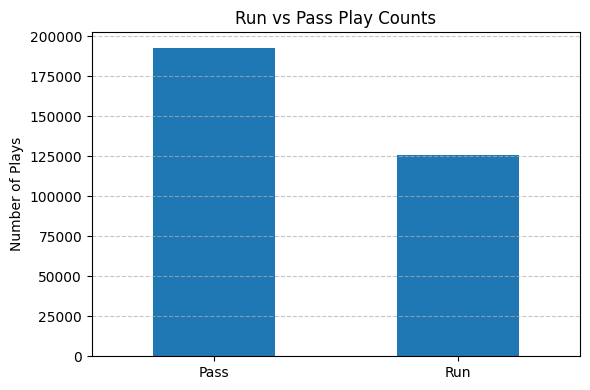

In [8]:
# Count run vs pass plays
play_counts = plays["was_run_play"].value_counts().sort_index()
play_counts.index = ["Pass", "Run"]  # 0 = Pass, 1 = Run

# Plot bar chart
plt.figure(figsize=(6, 4))
play_counts.plot(kind='bar')
plt.title("Run vs Pass Play Counts")
plt.ylabel("Number of Plays")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
plays = pd.read_csv("files/input/cleaned_plays.csv")


# Part 1 Supervised Learning Baseline

AUC: 0.7806633088095083
Accuracy: 0.7207132294972014
Precision: 0.6394932681929216
Log Loss: 0.5486172975754332


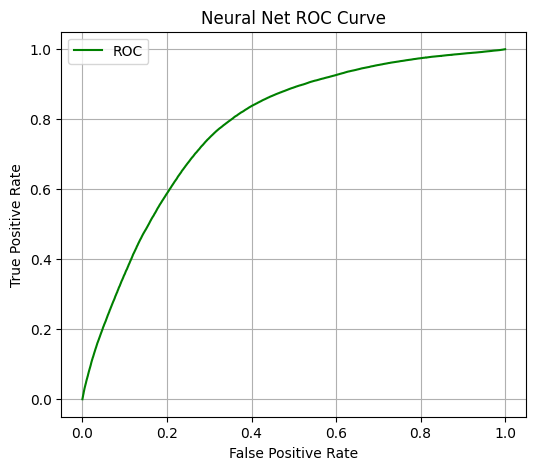

In [19]:
PREDICTOR_COLUMNS = ["season_cumul_run_avg", "season_cumul_pass_avg", "season_run_play_percentage", "is_home_team", "yardline_100", "half_seconds_remaining", "drive", "half", "down", "ydstogo", "shotgun", "score_differential"]

x = plays[PREDICTOR_COLUMNS]
y = plays["was_run_play"]
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.8, random_state=22)

LogReg = LogisticRegression(solver="liblinear").fit(x_train, y_train.ravel())

yhat = LogReg.predict_proba(x_test)
yhat_prob = yhat[:,1]
false_positive,true_positive, trash = roc_curve(y_test, yhat_prob)

# Predict class labels
yhat_class = LogReg.predict(x_test)

#  metrics
print("AUC:", roc_auc_score(y_test, yhat_prob))
print("Accuracy:", accuracy_score(y_test, yhat_class))
print("Precision:", precision_score(y_test, yhat_class))
print("Log Loss:", log_loss(y_test, yhat_prob))

#AUC Curve
false_positive, true_positive, _ = roc_curve(y_test, yhat_prob)
plt.figure(figsize=(6,5))
plt.plot(false_positive, true_positive, color="green", label="ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Net ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



Epoch 1/40
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.6421 - auc: 0.6937 - loss: 0.6383 - precision: 0.5514 - val_accuracy: 0.7213 - val_auc: 0.7893 - val_loss: 0.5382 - val_precision: 0.6310
Epoch 2/40
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.7137 - auc: 0.7688 - loss: 0.5584 - precision: 0.6339 - val_accuracy: 0.7240 - val_auc: 0.7916 - val_loss: 0.5368 - val_precision: 0.6337
Epoch 3/40
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.7120 - auc: 0.7728 - loss: 0.5525 - precision: 0.6250 - val_accuracy: 0.7240 - val_auc: 0.7917 - val_loss: 0.5352 - val_precision: 0.6360
Epoch 4/40
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7190 - auc: 0.7795 - loss: 0.5478 - precision: 0.6357 - val_accuracy: 0.7240 - val_auc: 0.7943 - val_loss: 0.5331 - val_precision: 0.6312
Epoch 5/40
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7207 - auc: 0.7819 - loss: 0.5452 - precision: 0.6382 - val_accuracy: 0.7249 - val_auc: 0.7957 - v

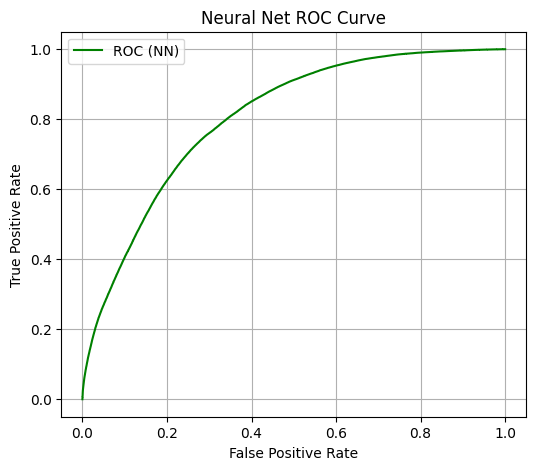

In [17]:


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Build the model
"""
#Iteration 1, simple
model = models.Sequential([
    layers.Input(shape=(len(PREDICTOR_COLUMNS),)),
    layers.Dense(32, activation="relu"),    
    layers.Dense(16, activation="relu"), 
    layers.Dense(1, activation="sigmoid") 
])

#Iteration 2, add dropouts
model = models.Sequential([
    layers.Input(shape=(len(PREDICTOR_COLUMNS),)),
    layers.Dense(32, activation="relu"),    
    layers.Dropout(0.3),   
    layers.Dense(16, activation="relu"), 
    layers.Dropout(0.3),    
    layers.Dense(1, activation="sigmoid") 
])

#Iteration 3, tweak dropouts


model = models.Sequential([
    layers.Input(shape=(len(PREDICTOR_COLUMNS),)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

#Iteration 4, add class weighting
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

model = models.Sequential([
    layers.Input(shape=(len(PREDICTOR_COLUMNS),)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
"""

#Iteration 4, remove class weighting, add batch normalizations

model = models.Sequential([
    layers.Input(shape=(len(PREDICTOR_COLUMNS),)),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.4),

    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.4),

    layers.Dense(16),
    layers.BatchNormalization(),
    layers.Activation("relu"),

    layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="precision")]
)

# Train the model
history = model.fit(
    x_train_scaled, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    #class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
loss, accuracy, auc, precision = model.evaluate(x_test_scaled, y_test, verbose=0)
print("Neural Net - Accuracy:", accuracy)
print("Neural Net - AUC:", auc)
print("Neural Net - Precision:", precision)

# Get predicted probabilities for log loss
y_pred_prob_nn = model.predict(x_test_scaled).ravel()
print("Neural Net - Log Loss:", log_loss(y_test, y_pred_prob_nn))

#AUC Curve
false_positive, true_positive, _ = roc_curve(y_test, y_pred_prob_nn)
plt.figure(figsize=(6, 5))
plt.plot(false_positive, true_positive, color="green", label="ROC (NN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Net ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Results and Analysis

After several iterations, rounds of tuning, and several comparable outcomes, I came across some results I am satisfied with. Slight advantage for the neural net across all metrics. 

| | Supervised Logistic Regression (LR) | Neural Network (NN)| Advantage |
| --- | ---------- | ---------- | -------- |
| Accuracy | 0.721 | 0.731 | NN |
| Precision | 0.639 | 0.649 | NN |
| AUC | 0.781 | 0.804 | NN |
| Log Loss | 0.549| 0.521 | NN |


# Conclusions

- We can make reasonably accurate run vs pass predictions using Logistic Regression.  
- The model shows relatively consistent predictive performance across different seasons.  
- Prediction accuracy varies by team — it performs noticeably better for some teams and worse for others.


# Areas for Improvement